In [1]:
import os
import sys
sys.path.insert(0,os.path.dirname(os.getcwd()))
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score

import src.models.modeling_pipeline as mp
import src.models.train_model as tm

In [2]:
# Select the data file to use
filename = os.path.join(os.path.dirname(os.getcwd()), 'data','interim','full_feature_data.csv')
# filename = os.path.join(os.path.dirname(os.getcwd()), 'data','interim','full_feature_cg_data.csv')

df = pd.read_csv(filename)
df.head()

,Tube_Alias,Flaw_ID,Angle,Amp_1,Amp_2,Amp_3,Amp_4,Amp_5,Amp_6,Amp_7,...,AB_Ratio_15,AB_Ratio_16,AB_Ratio_17,AB_Ratio_18,AB_Ratio_19,AB_Ratio_20,Flaw_Depth,Pct_Depth,Flaw_Volume,Flaw_Area
0,AP01,A,0,12.158630,17.616182,19.507299,12.688417,28.611131,23.380270,44.989959,...,1.956307,3.275930,1.817514,0.777416,0.866272,1.733430,0.076,10.3,0.864,11.3288
1,AP01,A,10,12.662390,13.679878,19.669931,14.483477,28.351937,18.583178,42.755353,...,1.985838,3.756354,1.795074,0.837584,0.896130,1.501476,0.076,10.3,0.864,11.3288
2,AP01,A,20,10.256701,13.404310,15.955676,13.250621,25.169557,18.774754,38.196417,...,1.938655,3.089216,1.856828,0.856594,0.853804,1.686915,0.076,10.3,0.864,11.3288
3,AP01,A,30,9.885306,8.746499,15.840469,16.280198,20.803812,19.185067,31.785403,...,1.932763,3.235533,1.879336,0.891017,0.882775,1.764685,0.076,10.3,0.864,11.3288
4,AP01,A,40,10.595372,13.148400,14.767161,13.241353,22.418596,17.189801,36.666878,...,1.895807,2.851098,1.837718,0.747698,0.844795,1.887925,0.076,10.3,0.864,11.3288


## Step 1: Create PCA components, and decide how many components to include in further model training

In [3]:
common_columns = ['Tube_Alias','Flaw_ID', 'Angle','Flaw_Depth']

# Create pca components
amp_features = []
phase_features = []
ab_ratio_features = []
a_features = []
b_features = []

for i in range(1,21):
    amp_features.append(f'Amp_{i}')
    phase_features.append(f'Phase_{i}')
    ab_ratio_features.append(f'AB_Ratio_{i}')
    a_features.append(f'A_Value_{i}')
    b_features.append(f'B_Value_{i}')
    
# Creating dataframes of PCA components for each feature
pca = PCA()
pca_amp = PCA()
pca_phase = PCA()
pca_ab = PCA()
pca_a = PCA()
pca_b = PCA()
X_all_reduced_train = pca.fit_transform(scale(df.drop(common_columns, axis=1))) 
X_amp_reduced_train = pca_amp.fit_transform(scale(df[amp_features]))
X_phase_reduced_train = pca_phase.fit_transform(scale(df[phase_features]))
X_AB_reduced_train = pca_ab.fit_transform(scale(df[ab_ratio_features]))
X_A_reduced_train = pca_a.fit_transform(scale(df[a_features]))
X_B_reduced_train = pca_b.fit_transform(scale(df[b_features]))


In [4]:
feature_list = mp.find_features(df, ['PCA'])
y_feature = 'Flaw_Depth'

In [5]:
# DECIDE WHICH COMPONENTS TO INCLUDE 

# # Components using all three feature types together
X_reduced_train = X_all_reduced_train
pca = pca

## Components for amplitude
# X_reduced_train = X_amp_reduced_train
# pca = pca_amp

## Components for phase
# X_reduced_train = X_phase_reduced_train
# pca = pca_phase

# # Components for AB ratio
# X_reduced_train =  X_AB_reduced_train
# pca = pca_ab

# # Components for A value
# X_reduced_train =  X_A_reduced_train
# pca = pca_a

# # Components for B value
# X_reduced_train =  X_B_reduced_train
# pca = pca_b


In [6]:
m = len(X_reduced_train)
kf_5 = model_selection.KFold(n_splits=5, shuffle=True, random_state=1)

# Decide method of regression - COMMENT OUT FOR SELECTION
regr = LinearRegression()
# regr = Ridge()
# regr = Lasso(alpha=0.1)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(regr, np.ones((m,1)), df[y_feature].ravel(), cv=kf_5, 
                                        scoring='neg_mean_squared_error').mean()    
mse.append(score)

In [7]:
# calculate MSE for increasing numbers of components
for i in np.arange(1, 20):
    score = -1*model_selection.cross_val_score(regr, X_reduced_train[:,:i], df[y_feature].ravel(), cv=kf_5, 
                                               scoring='neg_mean_squared_error').mean()
    mse.append(score)

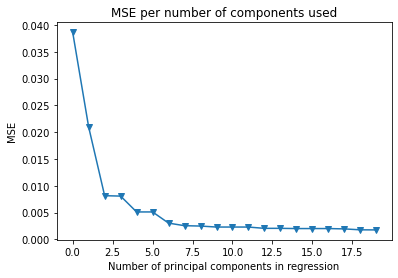

In [8]:
# Plot MSE
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('MSE per number of components used')
plt.xlim(xmin=-1);

In [9]:
# View the amount of variance explained by adding consecutive components
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)


array([61.77, 82.21, 87.35, 89.74, 91.05, 92.18, 93.03, 93.73, 94.33,
       94.88, 95.38, 95.85, 96.29, 96.68, 96.99, 97.27, 97.54, 97.76,
       97.96, 98.15, 98.32, 98.48, 98.63, 98.76, 98.89, 99.01, 99.12,
       99.22, 99.32, 99.4 , 99.48, 99.55, 99.62, 99.68, 99.73, 99.77,
       99.81, 99.84, 99.86, 99.88, 99.9 , 99.92, 99.93, 99.94, 99.95,
       99.96, 99.97, 99.98, 99.98, 99.98, 99.98, 99.98, 99.98, 99.98,
       99.98, 99.98, 99.98, 99.98, 99.98, 99.98, 99.98, 99.98, 99.98,
       99.98, 99.98, 99.98, 99.98, 99.98, 99.98, 99.98, 99.98, 99.98,
       99.98, 99.98, 99.98, 99.98, 99.98, 99.98, 99.98, 99.98, 99.98,
       99.98, 99.98, 99.98, 99.98, 99.98, 99.98, 99.98, 99.98, 99.98,
       99.98, 99.98, 99.98, 99.98, 99.98, 99.98, 99.98, 99.98, 99.98,
       99.98, 99.98, 99.98, 99.98])

### By analysing the mse for each additional components, for each dataset, we concluded that the best number of components to use were: 


**full_feature_cg_data:**
- Amplitude: 99% of the variance has been explained within the first four components
- Phase: The elbnow of the MSE performance is seen 6 or 7 components, where typically around **88%** of the variance is explained at this point. Gradual improvement is seen up to around 16 components, where 99% of variance is explained
- AB_ratio: The elbow is around 4 or 5 components, where typically **93-94%** of variance has been explained. This then continues to graudally improve with more components.
- If feeding all three features together into PCa together, then most variance is explained by 7-8 components.


**full_feature_data:**
- Amplitude: The majority of the variance is explained within the first two components
- Phase: The elbnow of the MSE performance is seen 6 or 7 components, where typically around **85%** of the variance is explained at this point. Gradual improvement is seen up to around 16 components, where 99% of variance is explained
- AB_ratio: The elbow is around 4 or 5 components, where typically **94-95%** of variance has been explained. This then continues to graudally improve with more components.


### THEREFORE, for our validation (aka test) set, we will use:
- **3 components** from aplitude
- **7 components** from phase
- **5 components** from AB_ratio
- For PCA components extracted from all features simultaneously, we will use **8 components**

And will test different combinations of these components to assess their performance


## Step 2: Create final model using selected number of PCA features

In [10]:
# Define columns for PCA
pca_amp_features = []
pca_phase_features = []
pca_ab_ratio_features = []

for i in range(1,21):
    pca_amp_features.append(f'PCA_Amp_{i}')
    pca_phase_features.append(f'PCA_Phase_{i}')
    pca_ab_ratio_features.append(f'PCA_AB_Ratio_{i}')

# Create dataframes for different PCA components
X_amp_reduced_train = pd.DataFrame(pca_amp.fit_transform(scale(df[amp_features])),columns=pca_amp_features)
X_phase_reduced_train = pd.DataFrame(pca_phase.fit_transform(scale(df[phase_features])),columns=pca_phase_features)
X_AB_reduced_train = pd.DataFrame(pca_ab.fit_transform(scale(df[ab_ratio_features])),columns=pca_ab_ratio_features)

# Selecting and adding the top numbers of PCA components, as per EDA above
df_train = pd.concat([df,X_amp_reduced_train.iloc[:,:3],X_phase_reduced_train.iloc[:,:7],
                X_AB_reduced_train.iloc[:,:5]], axis=1)

# PCA components to include in model
selected_PCA_components = pca_amp_features[:3] + pca_phase_features[:7] + pca_ab_ratio_features[:5]

In [11]:
groups_labels = tm.generate_groups(df_train)
no_folds = 5
gkf = tm.generate_groupcv_object(df_train[selected_PCA_components], df_train[y_feature], groups_labels, no_folds)

# regr = LinearRegression()
regr = Ridge()
# regr = Lasso(alpha=0.1)

cv_mse = cross_val_score(regr, df_train[selected_PCA_components], df_train[y_feature], cv = gkf, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(abs(cv_mse).mean())
print("Average CV RMSE: ", cv_rmse)

Average CV RMSE:  0.05856497075834336


## Step 3: Make predictions on test set


In [12]:
filename = os.path.join(os.path.dirname(os.getcwd()), 'data','interim','full_feature_test_data.csv')
test_df = pd.read_csv(filename)
# test_predictions = predict_regclas_model(test_df, feature_list, feature_list, y_feature, model_lasso, rf)



In [13]:
X_amp_reduced_train = pd.DataFrame(pca_amp.fit_transform(scale(test_df[amp_features])),columns=pca_amp_features)
X_phase_reduced_train = pd.DataFrame(pca_phase.fit_transform(scale(test_df[phase_features])),columns=pca_phase_features)
X_AB_reduced_train = pd.DataFrame(pca_ab.fit_transform(scale(test_df[ab_ratio_features])),columns=pca_ab_ratio_features)

# Selecting and adding the top numbers of PCA components, as per EDA in notebook 9
test_df = pd.concat([test_df,X_amp_reduced_train.iloc[:,:3],X_phase_reduced_train.iloc[:,:7],
                X_AB_reduced_train.iloc[:,:5]], axis=1)


In [14]:
regr.fit(df_train[selected_PCA_components], df_train[y_feature])

reg_prediction = regr.predict(test_df[selected_PCA_components])

In [ ]:
pd.DataFrame(reg_prediction).to_csv('pca_predictions.csv')